# Payment Date Prediction

## Importing related Libraries

In [48]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import xgboost as xgb
from pandas.core.series import Series
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

### Store the dataset into the Dataframe

In [49]:
ruta_archivo = "C:/Users/nombr/Desktop/Trabajo/ml/dataset.csv"
data = pd.read_csv(ruta_archivo)

In [50]:
data.shape

(50000, 19)

In [51]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   business_code           50000 non-null  object 
 1   cust_number             50000 non-null  object 
 2   name_customer           50000 non-null  object 
 3   clear_date              40000 non-null  object 
 4   buisness_year           50000 non-null  float64
 5   doc_id                  50000 non-null  float64
 6   posting_date            50000 non-null  object 
 7   document_create_date    50000 non-null  int64  
 8   document_create_date.1  50000 non-null  int64  
 9   due_in_date             50000 non-null  float64
 10  invoice_currency        50000 non-null  object 
 11  document type           50000 non-null  object 
 12  posting_id              50000 non-null  float64
 13  area_business           0 non-null      float64
 14  total_open_amount       50000 non-null

In [52]:
data.columns

Index(['business_code', 'cust_number', 'name_customer', 'clear_date',
       'buisness_year', 'doc_id', 'posting_date', 'document_create_date',
       'document_create_date.1', 'due_in_date', 'invoice_currency',
       'document type', 'posting_id', 'area_business', 'total_open_amount',
       'baseline_create_date', 'cust_payment_terms', 'invoice_id', 'isOpen'],
      dtype='object')

In [53]:
data.describe()

,buisness_year,doc_id,document_create_date,document_create_date.1,due_in_date,posting_id,area_business,total_open_amount,baseline_create_date,invoice_id,isOpen
count,50000.000000,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,50000.0,0.0,50000.000000,5.000000e+04,4.999400e+04,50000.000000
mean,2019.305700,2.012238e+09,2.019351e+07,2.019354e+07,2.019368e+07,1.0,NaN,32337.021651,2.019354e+07,2.011340e+09,0.200000
std,0.460708,2.885235e+08,4.496041e+03,4.482134e+03,4.470614e+03,0.0,NaN,39205.975231,4.482701e+03,2.766335e+08,0.400004
min,2019.000000,1.928502e+09,2.018123e+07,2.018123e+07,2.018122e+07,1.0,NaN,0.720000,2.018121e+07,1.928502e+09,0.000000
25%,2019.000000,1.929342e+09,2.019050e+07,2.019051e+07,2.019052e+07,1.0,NaN,4928.312500,2.019050e+07,1.929342e+09,0.000000
50%,2019.000000,1.929964e+09,2.019091e+07,2.019091e+07,2.019093e+07,1.0,NaN,17609.010000,2.019091e+07,1.929964e+09,0.000000
75%,2020.000000,1.930619e+09,2.020013e+07,2.020013e+07,2.020022e+07,1.0,NaN,47133.635000,2.020013e+07,1.930619e+09,0.000000
max,2020.000000,9.500000e+09,2.020052e+07,2.020052e+07,2.020071e+07,1.0,NaN,668593.360000,2.020052e+07,2.960636e+09,1.000000


# Data Cleaning

In [54]:
data.head()

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,document_create_date.1,due_in_date,invoice_currency,document type,posting_id,area_business,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,isOpen
0,U001,0200769623,WAL-MAR corp,2020-02-11 00:00:00,2020.0,1.930438e+09,2020-01-26,20200125,20200126,20200210.0,USD,RV,1.0,NaN,54273.28,20200126.0,NAH4,1.930438e+09,0
1,U001,0200980828,BEN E,2019-08-08 00:00:00,2019.0,1.929646e+09,2019-07-22,20190722,20190722,20190811.0,USD,RV,1.0,NaN,79656.60,20190722.0,NAD1,1.929646e+09,0
2,U001,0200792734,MDV/ trust,2019-12-30 00:00:00,2019.0,1.929874e+09,2019-09-14,20190914,20190914,20190929.0,USD,RV,1.0,NaN,2253.86,20190914.0,NAA8,1.929874e+09,0
3,CA02,0140105686,SYSC llc,NaN,2020.0,2.960623e+09,2020-03-30,20200330,20200330,20200410.0,CAD,RV,1.0,NaN,3299.70,20200331.0,CA10,2.960623e+09,1
4,U001,0200769623,WAL-MAR foundation,2019-11-25 00:00:00,2019.0,1.930148e+09,2019-11-13,20191113,20191113,20191128.0,USD,RV,1.0,NaN,33133.29,20191113.0,NAH4,1.930148e+09,0


Display the Null values percentage against every columns (compare to the total number of records)

In [55]:
null_count = data.isnull().sum()*100/50000
print("Column Name\tPercentage of Null Values\n")
for i,per in zip(data.columns,null_count):
    print(f"{i}\t {round(per, ndigits=4)}%")

Column Name	Percentage of Null Values

business_code	 0.0%
cust_number	 0.0%
name_customer	 0.0%
clear_date	 20.0%
buisness_year	 0.0%
doc_id	 0.0%
posting_date	 0.0%
document_create_date	 0.0%
document_create_date.1	 0.0%
due_in_date	 0.0%
invoice_currency	 0.0%
document type	 0.0%
posting_id	 0.0%
area_business	 100.0%
total_open_amount	 0.0%
baseline_create_date	 0.0%
cust_payment_terms	 0.0%
invoice_id	 0.012%
isOpen	 0.0%


In [56]:
data[['invoice_id', 'doc_id']]
(data['doc_id'] == data['invoice_id']).sum()

49994

In [57]:
data[['baseline_create_date','document_create_date','document_create_date.1']].corr().style.background_gradient(cmap='gist_ncar',vmin=0.999999)
print("Number of unique values in posting_id column: ",data['posting_id'].nunique())
print("Hence Posting ID is a constant column")
print("Number of unique values in posting_id column: ",data['isOpen'].nunique())
print("\nNumber of value count of each unique value:\n",data['isOpen'].value_counts())

Number of unique values in posting_id column:  1
Hence Posting ID is a constant column
Number of unique values in posting_id column:  2

Number of value count of each unique value:
 0    40000
1    10000
Name: isOpen, dtype: int64


drop all the following columns from the dataframe

'area_business'
"posting_id"
"invoice_id"
"document_create_date"
"isOpen"
'document type'
'document_create_date.1

In [58]:
drop_cols=['area_business',"posting_id","invoice_id","document_create_date","isOpen",'document type','document_create_date.1']
data=data.drop(columns=drop_cols)
data.head()

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,due_in_date,invoice_currency,total_open_amount,baseline_create_date,cust_payment_terms
0,U001,0200769623,WAL-MAR corp,2020-02-11 00:00:00,2020.0,1.930438e+09,2020-01-26,20200210.0,USD,54273.28,20200126.0,NAH4
1,U001,0200980828,BEN E,2019-08-08 00:00:00,2019.0,1.929646e+09,2019-07-22,20190811.0,USD,79656.60,20190722.0,NAD1
2,U001,0200792734,MDV/ trust,2019-12-30 00:00:00,2019.0,1.929874e+09,2019-09-14,20190929.0,USD,2253.86,20190914.0,NAA8
3,CA02,0140105686,SYSC llc,NaN,2020.0,2.960623e+09,2020-03-30,20200410.0,CAD,3299.70,20200331.0,CA10
4,U001,0200769623,WAL-MAR foundation,2019-11-25 00:00:00,2019.0,1.930148e+09,2019-11-13,20191128.0,USD,33133.29,20191113.0,NAH4


In [59]:
print(data.columns)  

Index(['business_code', 'cust_number', 'name_customer', 'clear_date',
       'buisness_year', 'doc_id', 'posting_date', 'due_in_date',
       'invoice_currency', 'total_open_amount', 'baseline_create_date',
       'cust_payment_terms'],
      dtype='object')


In [60]:
data.isnull().sum()

business_code               0
cust_number                 0
name_customer               0
clear_date              10000
buisness_year               0
doc_id                      0
posting_date                0
due_in_date                 0
invoice_currency            0
total_open_amount           0
baseline_create_date        0
cust_payment_terms          0
dtype: int64

Data type Conversion

In [61]:
data.dtypes

business_code            object
cust_number              object
name_customer            object
clear_date               object
buisness_year           float64
doc_id                  float64
posting_date             object
due_in_date             float64
invoice_currency         object
total_open_amount       float64
baseline_create_date    float64
cust_payment_terms       object
dtype: object

In [62]:
check_dtype =['clear_date','posting_date','due_in_date','baseline_create_date']
pd.DataFrame({'COLUMNS':list(check_dtype) ,'Data Type':data.dtypes[check_dtype]})

,COLUMNS,Data Type
clear_date,clear_date,object
posting_date,posting_date,object
due_in_date,due_in_date,float64
baseline_create_date,baseline_create_date,float64


converting date columns into date time formats

In [63]:
def convert_to_string(data,cols):
    for i in cols:
        data[i] = data[i].astype(np.int64)
        data[i] = data[i].astype(str)
    return data
data = convert_to_string(data,['baseline_create_date','due_in_date'])
date_cols = ['baseline_create_date','due_in_date','clear_date','posting_date']
for x in date_cols:
    data[x] = pd.to_datetime(data[x],format='%Y-%m-%d')

In [64]:
pd.DataFrame({'COLUMNS':list(date_cols) ,'Data Type':data.dtypes[date_cols]})


,COLUMNS,Data Type
baseline_create_date,baseline_create_date,datetime64[ns]
due_in_date,due_in_date,datetime64[ns]
clear_date,clear_date,datetime64[ns]
posting_date,posting_date,datetime64[ns]


In [65]:
data['invoice_currency'].value_counts()
pd.DataFrame(data['total_open_amount'])

,total_open_amount
0,54273.28
1,79656.60
2,2253.86
3,3299.70
4,33133.29
...,...
49995,3187.86
49996,6766.54
49997,6120.86
49998,63.48


In [66]:
# 1 CAD = 0.7 USD
data['converted_usd'] = np.where((data['invoice_currency']=='CAD'),data['total_open_amount']*0.7,data['total_open_amount'])
data.head()

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,due_in_date,invoice_currency,total_open_amount,baseline_create_date,cust_payment_terms,converted_usd
0,U001,0200769623,WAL-MAR corp,2020-02-11,2020.0,1.930438e+09,2020-01-26,2020-02-10,USD,54273.28,2020-01-26,NAH4,54273.28
1,U001,0200980828,BEN E,2019-08-08,2019.0,1.929646e+09,2019-07-22,2019-08-11,USD,79656.60,2019-07-22,NAD1,79656.60
2,U001,0200792734,MDV/ trust,2019-12-30,2019.0,1.929874e+09,2019-09-14,2019-09-29,USD,2253.86,2019-09-14,NAA8,2253.86
3,CA02,0140105686,SYSC llc,NaT,2020.0,2.960623e+09,2020-03-30,2020-04-10,CAD,3299.70,2020-03-31,CA10,2309.79
4,U001,0200769623,WAL-MAR foundation,2019-11-25,2019.0,1.930148e+09,2019-11-13,2019-11-28,USD,33133.29,2019-11-13,NAH4,33133.29


In [67]:
pd.DataFrame(data['converted_usd'])

,converted_usd
0,54273.28
1,79656.60
2,2253.86
3,2309.79
4,33133.29
...,...
49995,3187.86
49996,6766.54
49997,6120.86
49998,63.48


In [68]:
data['buisness_year'].value_counts()

2019.0    34715
2020.0    15285
Name: buisness_year, dtype: int64

In [69]:
del_cols = ['invoice_currency','total_open_amount']
data=data.drop(columns=del_cols)
data.head()

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,due_in_date,baseline_create_date,cust_payment_terms,converted_usd
0,U001,0200769623,WAL-MAR corp,2020-02-11,2020.0,1.930438e+09,2020-01-26,2020-02-10,2020-01-26,NAH4,54273.28
1,U001,0200980828,BEN E,2019-08-08,2019.0,1.929646e+09,2019-07-22,2019-08-11,2019-07-22,NAD1,79656.60
2,U001,0200792734,MDV/ trust,2019-12-30,2019.0,1.929874e+09,2019-09-14,2019-09-29,2019-09-14,NAA8,2253.86
3,CA02,0140105686,SYSC llc,NaT,2020.0,2.960623e+09,2020-03-30,2020-04-10,2020-03-31,CA10,2309.79
4,U001,0200769623,WAL-MAR foundation,2019-11-25,2019.0,1.930148e+09,2019-11-13,2019-11-28,2019-11-13,NAH4,33133.29


### Splitting the Data Set

In [70]:
data.columns[data.isna().any()].to_list()

['clear_date']

In [71]:
data['clear_date'].isna().sum()

10000

In [72]:
maindata = data.loc[~data['clear_date'].isnull()]
maindata = maindata.reset_index(drop=True)
nulldata = data.loc[data['clear_date'].isnull()]

In [73]:
maindata.shape

(40000, 11)

In [74]:
nulldata.shape

(10000, 11)

In [75]:
maindata.head()

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,due_in_date,baseline_create_date,cust_payment_terms,converted_usd
0,U001,0200769623,WAL-MAR corp,2020-02-11,2020.0,1.930438e+09,2020-01-26,2020-02-10,2020-01-26,NAH4,54273.280
1,U001,0200980828,BEN E,2019-08-08,2019.0,1.929646e+09,2019-07-22,2019-08-11,2019-07-22,NAD1,79656.600
2,U001,0200792734,MDV/ trust,2019-12-30,2019.0,1.929874e+09,2019-09-14,2019-09-29,2019-09-14,NAA8,2253.860
3,U001,0200769623,WAL-MAR foundation,2019-11-25,2019.0,1.930148e+09,2019-11-13,2019-11-28,2019-11-13,NAH4,33133.290
4,CA02,0140106181,THE corporation,2019-12-04,2019.0,2.960581e+09,2019-09-20,2019-10-04,2019-09-24,CA10,15558.088


In [76]:
nulldata.head()

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,due_in_date,baseline_create_date,cust_payment_terms,converted_usd
3,CA02,0140105686,SYSC llc,NaT,2020.0,2.960623e+09,2020-03-30,2020-04-10,2020-03-31,CA10,2309.79
7,U001,0200744019,TARG us,NaT,2020.0,1.930659e+09,2020-03-19,2020-04-03,2020-03-19,NAA8,11173.02
10,U001,0200418007,AM,NaT,2020.0,1.930611e+09,2020-03-11,2020-03-26,2020-03-11,NAA8,3525.59
14,U001,0200739534,OK systems,NaT,2020.0,1.930788e+09,2020-04-15,2020-04-30,2020-04-15,NAA8,121105.65
15,U001,0200353024,DECA corporation,NaT,2020.0,1.930817e+09,2020-04-23,2020-04-26,2020-04-16,NAM2,3726.06


In [77]:
# Note - New column Formula - Delay = clear_date - due_in_date
maindata['Delay'] = (maindata['clear_date'] - maindata['due_in_date'])
maindata.head()

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,due_in_date,baseline_create_date,cust_payment_terms,converted_usd,Delay
0,U001,0200769623,WAL-MAR corp,2020-02-11,2020.0,1.930438e+09,2020-01-26,2020-02-10,2020-01-26,NAH4,54273.280,1 days
1,U001,0200980828,BEN E,2019-08-08,2019.0,1.929646e+09,2019-07-22,2019-08-11,2019-07-22,NAD1,79656.600,-3 days
2,U001,0200792734,MDV/ trust,2019-12-30,2019.0,1.929874e+09,2019-09-14,2019-09-29,2019-09-14,NAA8,2253.860,92 days
3,U001,0200769623,WAL-MAR foundation,2019-11-25,2019.0,1.930148e+09,2019-11-13,2019-11-28,2019-11-13,NAH4,33133.290,-3 days
4,CA02,0140106181,THE corporation,2019-12-04,2019.0,2.960581e+09,2019-09-20,2019-10-04,2019-09-24,CA10,15558.088,61 days


In [78]:
avg_del = maindata.groupby('name_customer')['Delay'].mean(numeric_only=False).to_frame()
avg_del.rename(columns = {'Delay':'avg_del'},inplace=True)
avg_del.head()

,avg_del
name_customer,
11078 us,17 days
17135 associates,-10 days
17135 llc,-3 days
236008 associates,-3 days
99 CE,2 days


In [79]:
maindata['avg_delay'] = maindata['name_customer'].map(avg_del['avg_del'])

In [80]:
maindata['avg_delay'] = maindata['avg_delay'].dt.total_seconds()

In [81]:
maindata.head()

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,due_in_date,baseline_create_date,cust_payment_terms,converted_usd,Delay,avg_delay
0,U001,0200769623,WAL-MAR corp,2020-02-11,2020.0,1.930438e+09,2020-01-26,2020-02-10,2020-01-26,NAH4,54273.280,1 days,-2.336327e+05
1,U001,0200980828,BEN E,2019-08-08,2019.0,1.929646e+09,2019-07-22,2019-08-11,2019-07-22,NAD1,79656.600,-3 days,1.641600e+06
2,U001,0200792734,MDV/ trust,2019-12-30,2019.0,1.929874e+09,2019-09-14,2019-09-29,2019-09-14,NAA8,2253.860,92 days,6.264000e+05
3,U001,0200769623,WAL-MAR foundation,2019-11-25,2019.0,1.930148e+09,2019-11-13,2019-11-28,2019-11-13,NAH4,33133.290,-3 days,-1.900597e+05
4,CA02,0140106181,THE corporation,2019-12-04,2019.0,2.960581e+09,2019-09-20,2019-10-04,2019-09-24,CA10,15558.088,61 days,6.055855e+06


In [82]:
drop = ['Delay','clear_date']
maindata = maindata.drop(columns=drop)
maindata.head()

,business_code,cust_number,name_customer,buisness_year,doc_id,posting_date,due_in_date,baseline_create_date,cust_payment_terms,converted_usd,avg_delay
0,U001,0200769623,WAL-MAR corp,2020.0,1.930438e+09,2020-01-26,2020-02-10,2020-01-26,NAH4,54273.280,-2.336327e+05
1,U001,0200980828,BEN E,2019.0,1.929646e+09,2019-07-22,2019-08-11,2019-07-22,NAD1,79656.600,1.641600e+06
2,U001,0200792734,MDV/ trust,2019.0,1.929874e+09,2019-09-14,2019-09-29,2019-09-14,NAA8,2253.860,6.264000e+05
3,U001,0200769623,WAL-MAR foundation,2019.0,1.930148e+09,2019-11-13,2019-11-28,2019-11-13,NAH4,33133.290,-1.900597e+05
4,CA02,0140106181,THE corporation,2019.0,2.960581e+09,2019-09-20,2019-10-04,2019-09-24,CA10,15558.088,6.055855e+06


## Splitting of Train and the Test Data

In [83]:
X = maindata.iloc[:, 0:10]
X.head()

,business_code,cust_number,name_customer,buisness_year,doc_id,posting_date,due_in_date,baseline_create_date,cust_payment_terms,converted_usd
0,U001,0200769623,WAL-MAR corp,2020.0,1.930438e+09,2020-01-26,2020-02-10,2020-01-26,NAH4,54273.280
1,U001,0200980828,BEN E,2019.0,1.929646e+09,2019-07-22,2019-08-11,2019-07-22,NAD1,79656.600
2,U001,0200792734,MDV/ trust,2019.0,1.929874e+09,2019-09-14,2019-09-29,2019-09-14,NAA8,2253.860
3,U001,0200769623,WAL-MAR foundation,2019.0,1.930148e+09,2019-11-13,2019-11-28,2019-11-13,NAH4,33133.290
4,CA02,0140106181,THE corporation,2019.0,2.960581e+09,2019-09-20,2019-10-04,2019-09-24,CA10,15558.088


In [84]:
Y = maindata.iloc[:,-1:]
Y.head()

,avg_delay
0,-2.336327e+05
1,1.641600e+06
2,6.264000e+05
3,-1.900597e+05
4,6.055855e+06


In [85]:
X_train, X_loc_test, y_train, y_loc_test = train_test_split(X, Y, test_size=0.4)
print(X_train.shape)
print(X_loc_test.shape)
print(y_train.shape)
print(y_loc_test.shape)

(24000, 10)
(16000, 10)
(24000, 1)
(16000, 1)


In [86]:
X_val,X_test,y_val,y_test = train_test_split(X_loc_test, y_loc_test, test_size=0.5)
print(X_val.shape)
print(X_test.shape)
print(y_val.shape)
print(y_test.shape)

(8000, 10)
(8000, 10)
(8000, 1)
(8000, 1)


## Feature Engineering

In [87]:
X_train

,business_code,cust_number,name_customer,buisness_year,doc_id,posting_date,due_in_date,baseline_create_date,cust_payment_terms,converted_usd
15756,U001,0200803720,DEC us,2019.0,1.928839e+09,2019-02-22,2019-03-11,2019-02-16,NAM4,197.760
4745,U001,0200772670,ASSOCIAT llc,2019.0,1.929455e+09,2019-06-07,2019-06-22,2019-06-07,NAU5,267.140
18696,U001,200769623,WAL-MAR,2019.0,1.929618e+09,2019-07-14,2019-07-29,2019-07-14,NAH4,19167.010
717,U001,0200759878,SA foundation,2019.0,1.930152e+09,2019-11-15,2019-11-30,2019-11-15,NAH4,13905.360
22317,U001,0200769623,WAL-MAR co,2019.0,1.930059e+09,2019-10-28,2019-11-12,2019-10-28,NAH4,1118.710
...,...,...,...,...,...,...,...,...,...,...
11788,U001,0200712836,WINKLE associates,2019.0,1.930099e+09,2019-11-05,2019-11-20,2019-11-05,NAA8,46694.250
784,U001,0200769623,WAL-MAR systems,2019.0,1.930227e+09,2019-12-07,2019-12-22,2019-12-07,NAH4,683.910
17499,CA02,0140104429,COSTCO associates,2019.0,2.960568e+09,2019-07-25,2019-08-05,2019-07-26,CA10,23082.591
5122,U001,0200794332,COST trust,2019.0,1.929293e+09,2019-05-13,2019-05-28,2019-05-13,NAAX,8041.590


In [88]:
X_train.describe()

,buisness_year,doc_id,converted_usd
count,24000.000000,2.400000e+04,24000.000000
mean,2019.131042,2.014928e+09,30811.635111
std,0.337453,3.001766e+08,37065.733241
min,2019.000000,1.928502e+09,0.790000
25%,2019.000000,1.929182e+09,4451.310000
50%,2019.000000,1.929733e+09,16751.820000
75%,2019.000000,1.930208e+09,45540.428500
max,2020.000000,9.500000e+09,668593.360000


In [89]:
from sklearn.preprocessing import LabelEncoder

# Unir todas las etiquetas únicas
all_business_codes = pd.concat([X_train['business_code'], X_val['business_code'], X_test['business_code']]).unique()

# Crear una instancia del LabelEncoder
business_coder = LabelEncoder()

# Ajustar el LabelEncoder con todas las etiquetas únicas
business_coder.fit(all_business_codes)

# Transformar la columna 'business_code' en los conjuntos de entrenamiento, validación y prueba
X_train['business_code_enc'] = business_coder.transform(X_train['business_code'])
X_val['business_code_enc'] = business_coder.transform(X_val['business_code'])
X_test['business_code_enc'] = business_coder.transform(X_test['business_code'])

# Mostrar las columnas 'business_code' y 'business_code_enc' juntas en el DataFrame de entrenamiento
print(pd.DataFrame(X_train[['business_code', 'business_code_enc']]).head())


      business_code  business_code_enc
15756          U001                  1
4745           U001                  1
18696          U001                  1
717            U001                  1
22317          U001                  1


In [90]:
pd.DataFrame(X_train[['business_code','business_code_enc']])

,business_code,business_code_enc
15756,U001,1
4745,U001,1
18696,U001,1
717,U001,1
22317,U001,1
...,...,...
11788,U001,1
784,U001,1
17499,CA02,0
5122,U001,1


In [91]:
# Definir la función custom para eliminar columnas
def custom(col, traindf=X_train, valdf=X_val, testdf=X_test):
    traindf.drop(col, axis=1, inplace=True)
    valdf.drop(col, axis=1, inplace=True)
    testdf.drop(col, axis=1, inplace=True)
    return traindf, valdf, testdf

# Llamar a la función pasando la columna a eliminar y actualizar los DataFrames
X_train, X_val, X_test = custom(['business_code'])

# Verificar las primeras filas de los DataFrames actualizados
print(X_train.head())
print(X_val.head())
print(X_test.head())


      cust_number  name_customer  buisness_year        doc_id posting_date  \
15756  0200803720         DEC us         2019.0  1.928839e+09   2019-02-22   
4745   0200772670   ASSOCIAT llc         2019.0  1.929455e+09   2019-06-07   
18696   200769623       WAL-MAR          2019.0  1.929618e+09   2019-07-14   
717    0200759878  SA foundation         2019.0  1.930152e+09   2019-11-15   
22317  0200769623     WAL-MAR co         2019.0  1.930059e+09   2019-10-28   

      due_in_date baseline_create_date cust_payment_terms  converted_usd  \
15756  2019-03-11           2019-02-16               NAM4         197.76   
4745   2019-06-22           2019-06-07               NAU5         267.14   
18696  2019-07-29           2019-07-14               NAH4       19167.01   
717    2019-11-30           2019-11-15               NAH4       13905.36   
22317  2019-11-12           2019-10-28               NAH4        1118.71   

       business_code_enc  
15756                  1  
4745                

In [92]:
X_train['cust_number'] = X_train['cust_number'].str.replace('CCCA',"1").str.replace('CCU',"2").str.replace('CC',"3").astype(np.int64)
X_test['cust_number'] = X_test['cust_number'].str.replace('CCCA',"1").str.replace('CCU',"2").str.replace('CC',"3").astype(np.int64)
X_val['cust_number'] = X_val['cust_number'].str.replace('CCCA',"1").str.replace('CCU',"2").str.replace('CC',"3").astype(np.int64)

In [93]:
class EncoderExt(object):
    def __init__(self):
        self.label_encoder = LabelEncoder()
    def fit(self, data_list):
        self.label_encoder = self.label_encoder.fit(list(data_list) + ['Unknown'])
        self.classes_ = self.label_encoder.classes_
        return self
    def transform(self, data_list):
        new_data_list = list(data_list)
        for unique_item in np.unique(data_list):
            if unique_item not in self.label_encoder.classes_:
                new_data_list = ['Unknown' if x==unique_item else x for x in new_data_list]
        return self.label_encoder.transform(new_data_list)

In [94]:
label_encoder = EncoderExt()
label_encoder.fit(X_train['name_customer'])
X_train['name_customer_enc']=label_encoder.transform(X_train['name_customer'])
X_val['name_customer_enc']=label_encoder.transform(X_val['name_customer'])
X_test['name_customer_enc']=label_encoder.transform(X_test['name_customer'])

In [95]:
X_train ,X_val, X_test = custom(['name_customer'])

In [96]:
label_encoder1 = EncoderExt()
label_encoder1.fit(X_train['cust_payment_terms'])
X_train['cust_payment_terms_enc']=label_encoder1.transform(X_train['cust_payment_terms'])
X_val['cust_payment_terms_enc']=label_encoder1.transform(X_val['cust_payment_terms'])
X_test['cust_payment_terms_enc']=label_encoder1.transform(X_test['cust_payment_terms'])
X_train ,X_val, X_test = custom(['cust_payment_terms'])

In [97]:
X_train.dtypes
X_val.dtypes
X_test.dtypes

cust_number                        int64
buisness_year                    float64
doc_id                           float64
posting_date              datetime64[ns]
due_in_date               datetime64[ns]
baseline_create_date      datetime64[ns]
converted_usd                    float64
business_code_enc                  int32
name_customer_enc                  int32
cust_payment_terms_enc             int32
dtype: object

In [98]:
X_train['day_of_postingdate'] = X_train['posting_date'].dt.day
X_train['month_of_postingdate'] = X_train['posting_date'].dt.month
X_train['year_of_postingdate'] = X_train['posting_date'].dt.year
X_val['day_of_postingdate'] = X_val['posting_date'].dt.day
X_val['month_of_postingdate'] = X_val['posting_date'].dt.month
X_val['year_of_postingdate'] = X_val['posting_date'].dt.year
X_test['day_of_postingdate'] = X_test['posting_date'].dt.day
X_test['month_of_postingdate'] = X_test['posting_date'].dt.month
X_test['year_of_postingdate'] = X_test['posting_date'].dt.year

In [99]:
X_train ,X_val, X_test = custom(['posting_date'])

In [100]:
X_train['day_of_createdate'] = X_train['baseline_create_date'].dt.day
X_train['month_of_createdate'] = X_train['baseline_create_date'].dt.month
X_train['year_of_createdate'] = X_train['baseline_create_date'].dt.year
X_val['day_of_createdate'] = X_val['baseline_create_date'].dt.day
X_val['month_of_createdate'] = X_val['baseline_create_date'].dt.month
X_val['year_of_createdate'] = X_val['baseline_create_date'].dt.year
X_test['day_of_createdate'] = X_test['baseline_create_date'].dt.day
X_test['month_of_createdate'] = X_test['baseline_create_date'].dt.month
X_test['year_of_createdate'] = X_test['baseline_create_date'].dt.year

In [101]:
X_train ,X_val, X_test = custom(['baseline_create_date'])

In [102]:
X_train['day_of_due'] = X_train['due_in_date'].dt.day
X_train['month_of_due'] = X_train['due_in_date'].dt.month
X_train['year_of_due'] = X_train['due_in_date'].dt.year
X_val['day_of_due'] = X_val['due_in_date'].dt.day
X_val['month_of_due'] = X_val['due_in_date'].dt.month
X_val['year_of_due'] = X_val['due_in_date'].dt.year
X_test['day_of_due'] = X_test['due_in_date'].dt.day
X_test['month_of_due'] = X_test['due_in_date'].dt.month
X_test['year_of_due'] = X_test['due_in_date'].dt.year

In [103]:
X_train ,X_val, X_test = custom(['due_in_date'])

In [104]:
X_train.dtypes
X_val.dtypes
X_test.dtypes

cust_number                 int64
buisness_year             float64
doc_id                    float64
converted_usd             float64
business_code_enc           int32
name_customer_enc           int32
cust_payment_terms_enc      int32
day_of_postingdate          int64
month_of_postingdate        int64
year_of_postingdate         int64
day_of_createdate           int64
month_of_createdate         int64
year_of_createdate          int64
day_of_due                  int64
month_of_due                int64
year_of_due                 int64
dtype: object

## Feature Selection

### Filter Method

In [105]:
#VarianceThreshold Function
from sklearn.feature_selection import VarianceThreshold
constant_filter = VarianceThreshold(threshold=0)
constant_filter.fit(X_train)
len(X_train.columns[constant_filter.get_support()])

16

In [106]:
constant_columns = [column for column in X_train.columns
                    if column not in X_train.columns[constant_filter.get_support()]]
print(len(constant_columns))

0


In [107]:
x_train_T = X_train.T
print(x_train_T.duplicated().sum())

0


In [108]:
duplicated_columns = x_train_T[x_train_T.duplicated()].index.values

In [109]:
def handling_correlation(X_train,threshold=0.8):
    corr_features = set()
    corr_matrix = X_train.corr()
    for i in range(len(corr_matrix .columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) >threshold:
                colname = corr_matrix.columns[i]
                corr_features.add(colname)
    return list(corr_features)

<AxesSubplot:title={'center':'Pearson Correlation of Features'}>

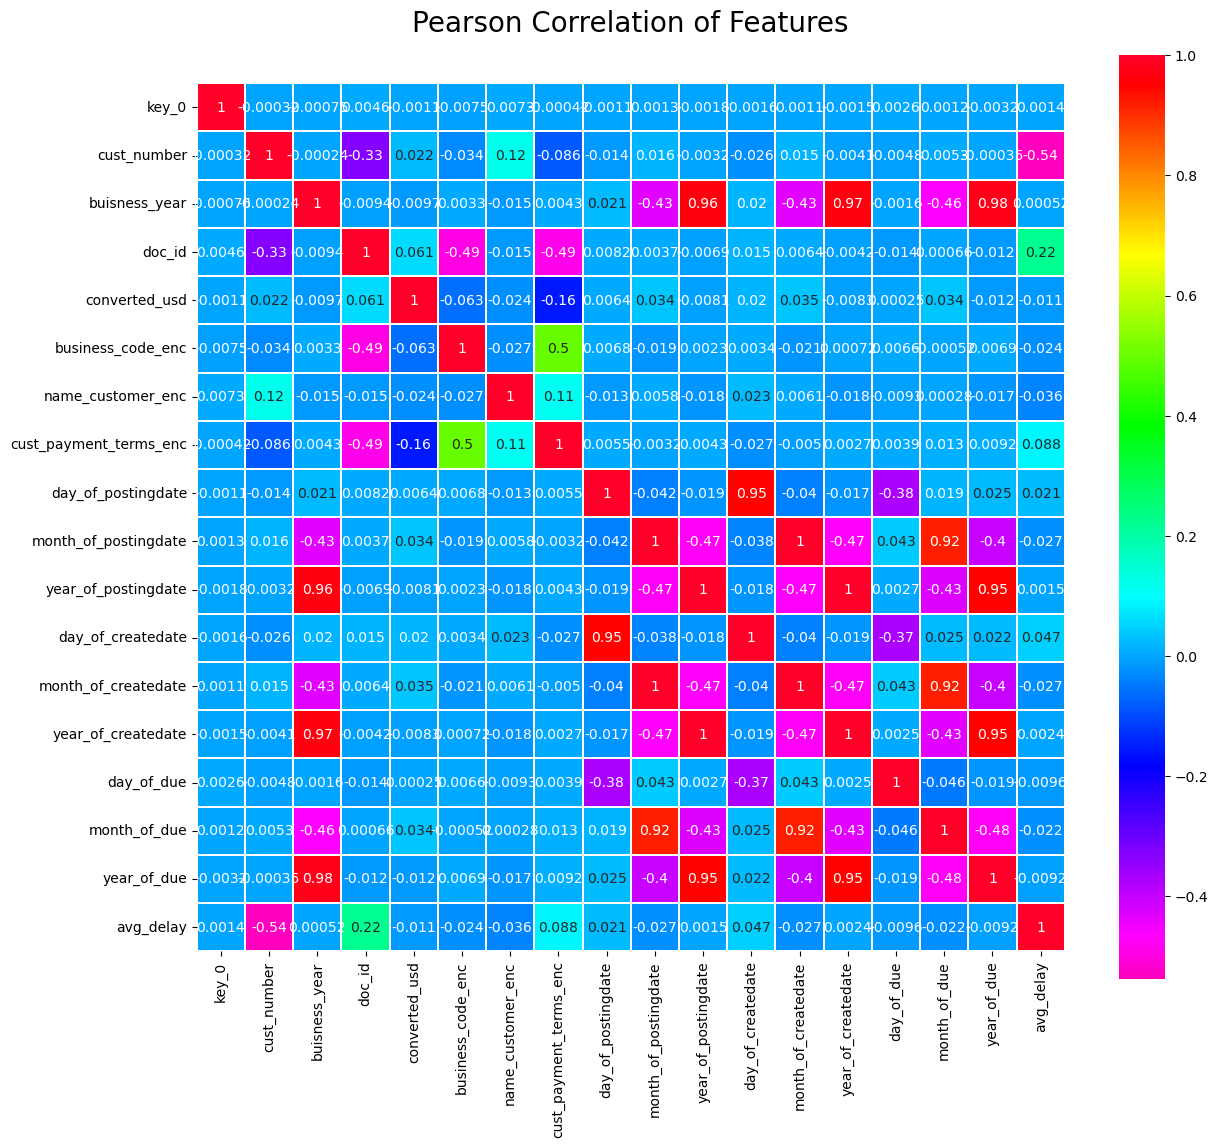

In [110]:
train=X_train.copy()
handling_correlation(train,threshold=0.85)
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=20)
sns.heatmap(X_train.merge(y_train , on = X_train.index ).corr(),linewidths=0.1,vmax=1.0,
            square=True, cmap='gist_rainbow_r', linecolor='white', annot=True)

In [111]:
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=0.8)
sel.fit(X_train)
sel.variances_

array([1.78144835e+15, 1.13869748e-01, 9.01022584e+16, 1.37381134e+09,
       2.83831660e-01, 1.07042762e+06, 1.38868635e+02, 7.59685563e+01,
       1.22787419e+01, 1.14172915e-01, 7.75187895e+01, 1.22852708e+01,
       1.14392771e-01, 7.63156738e+01, 1.21002291e+01, 1.17359373e-01])

## Modelling

### Linear Regression

In [112]:
MSE_Score = []
R2_Score = []
Algorithm = []
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [113]:
from sklearn.linear_model import LinearRegression
Algorithm.append('LinearRegression')
regressor = LinearRegression()
regressor.fit(X_train, y_train)
predicted= regressor.predict(X_test)

In [114]:
MSE_Score.append(mean_squared_error(y_test, predicted))
R2_Score.append(r2_score(y_test, predicted))
print("MSE Score on Train Data: ",mean_squared_error(y_test, predicted))
print("R2 Score on Train Data: ",r2_score(y_test, predicted))

MSE Score on Train Data:  319510994360.34174
R2 Score on Train Data:  0.3241189400554578


In [115]:
predict_test= regressor.predict(X_val)
print("MSE Score on Validation Data: ",mean_squared_error(y_val, predict_test, squared=False))
print("R2 Score on Validation: ",r2_score(y_val, predict_test))

MSE Score on Validation Data:  542795.8602988855
R2 Score on Validation:  0.33016107218507973


In [116]:
for i in Algorithm, MSE_Score, R2_Score:
    print(i,end=',')

['LinearRegression'],[319510994360.34174],[0.3241189400554578],

### Vector Regression

In [117]:
from sklearn.svm import SVR
Algorithm.append('Support Vector Regression')
svmregressor = SVR()
svmregressor.fit(X_train, y_train.values.ravel())
svmpredicted= svmregressor.predict(X_test)

In [118]:
MSE_Score.append(mean_squared_error(y_test, svmpredicted))
R2_Score.append(r2_score(y_test, svmpredicted))
print("MSE Score on Train Data: ",mean_squared_error(y_test, svmpredicted))
print("R2 Score on Train Data: ",r2_score(y_test, svmpredicted))

MSE Score on Train Data:  476717637179.378
R2 Score on Train Data:  -0.008429843098533008


In [119]:
svmpredict_test= svmregressor.predict(X_val)
print("MSE Score on Validation Data: ",mean_squared_error(y_val, svmpredict_test, squared=False))
print("R2 Score on Validation: ",r2_score(y_val, svmpredict_test))

MSE Score on Validation Data:  665561.2600780404
R2 Score on Validation:  -0.007101864612969244


In [120]:
for i in Algorithm, MSE_Score, R2_Score:
    print(i,end=',')

['LinearRegression', 'Support Vector Regression'],[319510994360.34174, 476717637179.378],[0.3241189400554578, -0.008429843098533008],

## Tree Regression

In [121]:
from sklearn.tree import DecisionTreeRegressor
Algorithm.append('Decision Tree Regression')
dsregressor = DecisionTreeRegressor()
dsregressor.fit(X_train, y_train.values.ravel())
dspredicted= dsregressor.predict(X_test)

In [122]:
MSE_Score.append(mean_squared_error(y_test, dspredicted))
R2_Score.append(r2_score(y_test, dspredicted))
print("MSE Score on Train Data: ",mean_squared_error(y_test, dspredicted))
print("R2 Score on Train Data: ",r2_score(y_test, dspredicted))

MSE Score on Train Data:  197060124255.36887
R2 Score on Train Data:  0.5831467210661544


In [123]:
dspredict_test= dsregressor.predict(X_val)
print("MSE Score on Validation Data: ",mean_squared_error(y_val, dspredict_test, squared=False))
print("R2 Score on Validation: ",r2_score(y_val, dspredict_test))

MSE Score on Validation Data:  419504.8713996701
R2 Score on Validation:  0.599897425302007


In [124]:
for i in Algorithm, MSE_Score, R2_Score:
    print(i,end=',')

['LinearRegression', 'Support Vector Regression', 'Decision Tree Regression'],[319510994360.34174, 476717637179.378, 197060124255.36887],[0.3241189400554578, -0.008429843098533008, 0.5831467210661544],

## Forest Regression

In [125]:
from sklearn.ensemble import RandomForestRegressor
Algorithm.append('Random Forest Regression')
rfregressor = RandomForestRegressor()
rfregressor.fit(X_train, y_train.values.ravel())
rfpredicted= rfregressor.predict(X_test)

In [126]:
MSE_Score.append(mean_squared_error(y_test, rfpredicted))
R2_Score.append(r2_score(y_test, rfpredicted))
print("MSE Score on Train Data: ",mean_squared_error(y_test, rfpredicted))
print("R2 Score on Train Data: ",r2_score(y_test, rfpredicted))

MSE Score on Train Data:  121434609754.47081
R2 Score on Train Data:  0.7431219763842001


In [127]:
rfpredict_test= rfregressor.predict(X_val)
print("MSE Score on Validation Data: ",mean_squared_error(y_val, rfpredict_test, squared=False))
print("R2 Score on Validation: ",r2_score(y_val, rfpredict_test))

MSE Score on Validation Data:  321990.14977120387
R2 Score on Validation:  0.7642875610344898


In [128]:
for i in Algorithm, MSE_Score, R2_Score:
    print(i,end=',')

['LinearRegression', 'Support Vector Regression', 'Decision Tree Regression', 'Random Forest Regression'],[319510994360.34174, 476717637179.378, 197060124255.36887, 121434609754.47081],[0.3241189400554578, -0.008429843098533008, 0.5831467210661544, 0.7431219763842001],

## Extreme Gradient Boost Regression

In [129]:
import xgboost as xgb
Algorithm.append('XGB Regressor')
xgbregressor = xgb.XGBRegressor()
xgbregressor.fit(X_train, y_train)
xgbpredicted = xgbregressor.predict(X_test)

In [130]:
MSE_Score.append(mean_squared_error(y_test, xgbpredicted))
R2_Score.append(r2_score(y_test, xgbpredicted))
print("MSE Score on Train Data: ",mean_squared_error(y_test, xgbpredicted))
print("R2 Score on Train Data: ",r2_score(y_test, xgbpredicted))

MSE Score on Train Data:  147270397768.60837
R2 Score on Train Data:  0.6884699609740375


In [131]:
xgbpredict_test= xgbregressor.predict(X_val)
print("MSE Score on Validation Data: ",mean_squared_error(y_val, xgbpredict_test, squared=False))
print("R2 Score on Validation: ",r2_score(y_val, xgbpredict_test))

MSE Score on Validation Data:  369418.8911199779
R2 Score on Validation:  0.6897330402286994


In [132]:
for i in Algorithm, MSE_Score, R2_Score:
    print(i,end=',')

['LinearRegression', 'Support Vector Regression', 'Decision Tree Regression', 'Random Forest Regression', 'XGB Regressor'],[319510994360.34174, 476717637179.378, 197060124255.36887, 121434609754.47081, 147270397768.60837],[0.3241189400554578, -0.008429843098533008, 0.5831467210661544, 0.7431219763842001, 0.6884699609740375],

In [133]:
pd.DataFrame({'Algorithms':Algorithm,'MSE Scores':MSE_Score,'R2 Score':R2_Score})

,Algorithms,MSE Scores,R2 Score
0,LinearRegression,3.195110e+11,0.324119
1,Support Vector Regression,4.767176e+11,-0.008430
2,Decision Tree Regression,1.970601e+11,0.583147
3,Random Forest Regression,1.214346e+11,0.743122
4,XGB Regressor,1.472704e+11,0.688470


In [134]:
# Asegurarse de que y_train sea un array unidimensional
y_train = np.ravel(y_train)

# Crear una instancia del RandomForestRegressor
regressorfinal = RandomForestRegressor()

# Ajustar el modelo con los datos de entrenamiento
regressorfinal.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
predictedfinal = regressorfinal.predict(X_test)

# Realizar predicciones en el conjunto de validación
predict_testfinal = regressorfinal.predict(X_val)

# Mostrar las primeras predicciones para verificar
print(predictedfinal[:5])
print(predict_testfinal[:5])

[ 890618.55319149  308485.11062214 5401921.09090909  825347.36842105
 -225154.63917526]
[ 112780.25738526   25944.68571429 -220079.18088737 -220079.18088737
 -233632.65306122]


In [135]:
mean_squared_error(y_test,predictedfinal,squared=False)

347440.96856655023

In [136]:
mean_squared_error(y_val,predict_testfinal,squared=False)

324133.6962456813

In [137]:
r2_score(y_test, predictedfinal)

0.7446437312894648

In [138]:
r2_score(y_val, predict_testfinal)

0.761138754319516

In [139]:
regressorfinal.score(X_train, y_train)

0.9714365123941441

In [140]:
regressorfinal.score(X_val, y_val)

0.761138754319516

In [141]:
regressorfinal.score(X_test, y_test)

0.7446437312894648

In [142]:
nulldata

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,due_in_date,baseline_create_date,cust_payment_terms,converted_usd
3,CA02,0140105686,SYSC llc,NaT,2020.0,2.960623e+09,2020-03-30,2020-04-10,2020-03-31,CA10,2309.79
7,U001,0200744019,TARG us,NaT,2020.0,1.930659e+09,2020-03-19,2020-04-03,2020-03-19,NAA8,11173.02
10,U001,0200418007,AM,NaT,2020.0,1.930611e+09,2020-03-11,2020-03-26,2020-03-11,NAA8,3525.59
14,U001,0200739534,OK systems,NaT,2020.0,1.930788e+09,2020-04-15,2020-04-30,2020-04-15,NAA8,121105.65
15,U001,0200353024,DECA corporation,NaT,2020.0,1.930817e+09,2020-04-23,2020-04-26,2020-04-16,NAM2,3726.06
...,...,...,...,...,...,...,...,...,...,...,...
49975,U001,0200769623,WAL-MAR in,NaT,2020.0,1.930625e+09,2020-03-10,2020-03-25,2020-03-10,NAH4,13114.99
49980,U001,0200769623,WAL-MAR corporation,NaT,2020.0,1.930851e+09,2020-05-03,2020-05-18,2020-05-03,NAH4,8899.71
49982,U001,0200148860,DOLLA co,NaT,2020.0,1.930638e+09,2020-03-11,2020-03-26,2020-03-11,NAA8,4967.06
49992,U001,0200900909,SYSCO co,NaT,2020.0,1.930702e+09,2020-03-25,2020-04-09,2020-03-25,NAA8,1998.64


In [143]:
# Asegúrate de definir tu ruta local correctamente
ruta_local = "C:\\Users\\nombr\\Desktop\\Trabajo\\ml\\nulldata.csv"

# Guardar el DataFrame nulldata en la ruta especificada
nulldata.to_csv(ruta_local)


In [144]:
nulldata.shape

(10000, 11)

In [145]:
nulldata.describe()

,buisness_year,doc_id,converted_usd
count,10000.0,1.000000e+04,10000.000000
mean,2020.0,2.007181e+09,32096.100588
std,0.0,2.690139e+08,35445.575943
min,2020.0,1.930535e+09,0.720000
25%,2020.0,1.930660e+09,5602.225000
50%,2020.0,1.930731e+09,19020.845000
75%,2020.0,1.930819e+09,47817.180000
max,2020.0,2.960636e+09,653644.800000


In [146]:
nulldata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 3 to 49995
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   business_code         10000 non-null  object        
 1   cust_number           10000 non-null  object        
 2   name_customer         10000 non-null  object        
 3   clear_date            0 non-null      datetime64[ns]
 4   buisness_year         10000 non-null  float64       
 5   doc_id                10000 non-null  float64       
 6   posting_date          10000 non-null  datetime64[ns]
 7   due_in_date           10000 non-null  datetime64[ns]
 8   baseline_create_date  10000 non-null  datetime64[ns]
 9   cust_payment_terms    10000 non-null  object        
 10  converted_usd         10000 non-null  float64       
dtypes: datetime64[ns](4), float64(3), object(4)
memory usage: 937.5+ KB


In [147]:
#BP
nulldata1=nulldata.copy()
nulldata1

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,due_in_date,baseline_create_date,cust_payment_terms,converted_usd
3,CA02,0140105686,SYSC llc,NaT,2020.0,2.960623e+09,2020-03-30,2020-04-10,2020-03-31,CA10,2309.79
7,U001,0200744019,TARG us,NaT,2020.0,1.930659e+09,2020-03-19,2020-04-03,2020-03-19,NAA8,11173.02
10,U001,0200418007,AM,NaT,2020.0,1.930611e+09,2020-03-11,2020-03-26,2020-03-11,NAA8,3525.59
14,U001,0200739534,OK systems,NaT,2020.0,1.930788e+09,2020-04-15,2020-04-30,2020-04-15,NAA8,121105.65
15,U001,0200353024,DECA corporation,NaT,2020.0,1.930817e+09,2020-04-23,2020-04-26,2020-04-16,NAM2,3726.06
...,...,...,...,...,...,...,...,...,...,...,...
49975,U001,0200769623,WAL-MAR in,NaT,2020.0,1.930625e+09,2020-03-10,2020-03-25,2020-03-10,NAH4,13114.99
49980,U001,0200769623,WAL-MAR corporation,NaT,2020.0,1.930851e+09,2020-05-03,2020-05-18,2020-05-03,NAH4,8899.71
49982,U001,0200148860,DOLLA co,NaT,2020.0,1.930638e+09,2020-03-11,2020-03-26,2020-03-11,NAA8,4967.06
49992,U001,0200900909,SYSCO co,NaT,2020.0,1.930702e+09,2020-03-25,2020-04-09,2020-03-25,NAA8,1998.64


In [148]:
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Crear una instancia de LabelEncoder
business_codern = LabelEncoder()

# Ajustar el codificador con los valores de 'business_code'
business_codern.fit(nulldata['business_code'])

# Transformar y asignar los valores codificados a una nueva columna usando el método assign
nulldata = nulldata.assign(business_code_enc=business_codern.transform(nulldata['business_code']))

# Asegurarnos de que 'cust_number' sea de tipo string antes de realizar el reemplazo
nulldata['cust_number'] = nulldata['cust_number'].astype(str)

# Realizar el reemplazo y conversión de la columna 'cust_number'
nulldata = nulldata.assign(
    cust_number=nulldata['cust_number']
    .str.replace('CCCA', "1", regex=False)
    .str.replace('CCU', "2", regex=False)
    .str.replace('CC', "3", regex=False)
    .astype(np.int64)
)

In [149]:
nulldata['day_of_cleardate'] = nulldata['clear_date'].dt.day
nulldata['month_of_cleardate'] = nulldata['clear_date'].dt.month
nulldata['year_of_cleardate'] = nulldata['clear_date'].dt.year
nulldata['day_of_postingdate'] = nulldata['posting_date'].dt.day
nulldata['month_of_postingdate'] = nulldata['posting_date'].dt.month
nulldata['year_of_postingdate'] = nulldata['posting_date'].dt.year
nulldata['day_of_due'] = nulldata['due_in_date'].dt.day
nulldata['month_of_due'] = nulldata['due_in_date'].dt.month
nulldata['year_of_due'] = nulldata['due_in_date'].dt.year
nulldata['day_of_createdate'] = nulldata['baseline_create_date'].dt.day
nulldata['month_of_createdate'] = nulldata['baseline_create_date'].dt.month
nulldata['year_of_createdate'] = nulldata['baseline_create_date'].dt.year

In [150]:
nulldata['cust_payment_terms_enc']=label_encoder1.transform(nulldata['cust_payment_terms'])
nulldata['business_code_enc']=label_encoder1.transform(nulldata['business_code'])
nulldata['name_customer_enc']=label_encoder.transform(nulldata['name_customer'])

In [151]:
nulldata.dtypes

business_code                     object
cust_number                        int64
name_customer                     object
clear_date                datetime64[ns]
buisness_year                    float64
doc_id                           float64
posting_date              datetime64[ns]
due_in_date               datetime64[ns]
baseline_create_date      datetime64[ns]
cust_payment_terms                object
converted_usd                    float64
business_code_enc                  int32
day_of_cleardate                 float64
month_of_cleardate               float64
year_of_cleardate                float64
day_of_postingdate                 int64
month_of_postingdate               int64
year_of_postingdate                int64
day_of_due                         int64
month_of_due                       int64
year_of_due                        int64
day_of_createdate                  int64
month_of_createdate                int64
year_of_createdate                 int64
cust_payment_ter

In [152]:
drop_c=['business_code',"baseline_create_date","due_in_date","posting_date","name_customer","clear_date","cust_payment_terms",'day_of_cleardate',"month_of_cleardate","year_of_cleardate"]
nulldata=nulldata.drop(columns=drop_c)
nulldata.head()

,cust_number,buisness_year,doc_id,converted_usd,business_code_enc,day_of_postingdate,month_of_postingdate,year_of_postingdate,day_of_due,month_of_due,year_of_due,day_of_createdate,month_of_createdate,year_of_createdate,cust_payment_terms_enc,name_customer_enc
3,140105686,2020.0,2.960623e+09,2309.79,67,30,3,2020,10,4,2020,31,3,2020,5,2717
7,200744019,2020.0,1.930659e+09,11173.02,67,19,3,2020,3,4,2020,19,3,2020,20,2804
10,200418007,2020.0,1.930611e+09,3525.59,67,11,3,2020,26,3,2020,11,3,2020,20,91
14,200739534,2020.0,1.930788e+09,121105.65,67,15,4,2020,30,4,2020,15,4,2020,20,2024
15,200353024,2020.0,1.930817e+09,3726.06,67,23,4,2020,26,4,2020,16,4,2020,36,720


In [153]:
nulldata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 3 to 49995
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   cust_number             10000 non-null  int64  
 1   buisness_year           10000 non-null  float64
 2   doc_id                  10000 non-null  float64
 3   converted_usd           10000 non-null  float64
 4   business_code_enc       10000 non-null  int32  
 5   day_of_postingdate      10000 non-null  int64  
 6   month_of_postingdate    10000 non-null  int64  
 7   year_of_postingdate     10000 non-null  int64  
 8   day_of_due              10000 non-null  int64  
 9   month_of_due            10000 non-null  int64  
 10  year_of_due             10000 non-null  int64  
 11  day_of_createdate       10000 non-null  int64  
 12  month_of_createdate     10000 non-null  int64  
 13  year_of_createdate      10000 non-null  int64  
 14  cust_payment_terms_enc  10000 non-null

In [154]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8000 entries, 17602 to 30147
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   cust_number             8000 non-null   int64  
 1   buisness_year           8000 non-null   float64
 2   doc_id                  8000 non-null   float64
 3   converted_usd           8000 non-null   float64
 4   business_code_enc       8000 non-null   int32  
 5   name_customer_enc       8000 non-null   int32  
 6   cust_payment_terms_enc  8000 non-null   int32  
 7   day_of_postingdate      8000 non-null   int64  
 8   month_of_postingdate    8000 non-null   int64  
 9   year_of_postingdate     8000 non-null   int64  
 10  day_of_createdate       8000 non-null   int64  
 11  month_of_createdate     8000 non-null   int64  
 12  year_of_createdate      8000 non-null   int64  
 13  day_of_due              8000 non-null   int64  
 14  month_of_due            8000 non-nu

In [155]:
X_test.columns
nulldata.columns
nulldata2=nulldata[['cust_number', 'buisness_year', 'doc_id', 'converted_usd',
       'business_code_enc', 'name_customer_enc', 'cust_payment_terms_enc',
       'day_of_postingdate', 'month_of_postingdate', 'year_of_postingdate',
       'day_of_createdate', 'month_of_createdate', 'year_of_createdate',
       'day_of_due', 'month_of_due', 'year_of_due']]

In [156]:
nulldata2

,cust_number,buisness_year,doc_id,converted_usd,business_code_enc,name_customer_enc,cust_payment_terms_enc,day_of_postingdate,month_of_postingdate,year_of_postingdate,day_of_createdate,month_of_createdate,year_of_createdate,day_of_due,month_of_due,year_of_due
3,140105686,2020.0,2.960623e+09,2309.79,67,2717,5,30,3,2020,31,3,2020,10,4,2020
7,200744019,2020.0,1.930659e+09,11173.02,67,2804,20,19,3,2020,19,3,2020,3,4,2020
10,200418007,2020.0,1.930611e+09,3525.59,67,91,20,11,3,2020,11,3,2020,26,3,2020
14,200739534,2020.0,1.930788e+09,121105.65,67,2024,20,15,4,2020,15,4,2020,30,4,2020
15,200353024,2020.0,1.930817e+09,3726.06,67,720,36,23,4,2020,16,4,2020,26,4,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49975,200769623,2020.0,1.930625e+09,13114.99,67,2993,34,10,3,2020,10,3,2020,25,3,2020
49980,200769623,2020.0,1.930851e+09,8899.71,67,2991,34,3,5,2020,3,5,2020,18,5,2020
49982,200148860,2020.0,1.930638e+09,4967.06,67,797,20,11,3,2020,11,3,2020,26,3,2020
49992,200900909,2020.0,1.930702e+09,1998.64,67,2763,20,25,3,2020,25,3,2020,9,4,2020


In [157]:
final_result = regressorfinal.predict(nulldata2)
final_result

array([ 278738.85738402,  237149.10273556, -220892.28715875, ...,
       -605505.69375452,   62803.30521243,  146425.54147357])

In [158]:
final_result = pd.Series(final_result,name='avg_delay')

In [159]:
final_result

0       278738.857384
1       237149.102736
2      -220892.287159
3       103308.110971
4      -360244.067797
            ...      
9995   -217102.774695
9996   -220079.180887
9997   -605505.693755
9998     62803.305212
9999    146425.541474
Name: avg_delay, Length: 10000, dtype: float64

In [160]:
nulldata1.reset_index(drop=True,inplace=True)
Final = nulldata1.merge(final_result , on = nulldata.index )

In [161]:
Final

,key_0,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,due_in_date,baseline_create_date,cust_payment_terms,converted_usd,avg_delay
0,3,CA02,0140105686,SYSC llc,NaT,2020.0,2.960623e+09,2020-03-30,2020-04-10,2020-03-31,CA10,2309.79,278738.857384
1,7,U001,0200744019,TARG us,NaT,2020.0,1.930659e+09,2020-03-19,2020-04-03,2020-03-19,NAA8,11173.02,237149.102736
2,10,U001,0200418007,AM,NaT,2020.0,1.930611e+09,2020-03-11,2020-03-26,2020-03-11,NAA8,3525.59,-220892.287159
3,14,U001,0200739534,OK systems,NaT,2020.0,1.930788e+09,2020-04-15,2020-04-30,2020-04-15,NAA8,121105.65,103308.110971
4,15,U001,0200353024,DECA corporation,NaT,2020.0,1.930817e+09,2020-04-23,2020-04-26,2020-04-16,NAM2,3726.06,-360244.067797
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,49975,U001,0200769623,WAL-MAR in,NaT,2020.0,1.930625e+09,2020-03-10,2020-03-25,2020-03-10,NAH4,13114.99,-217102.774695
9996,49980,U001,0200769623,WAL-MAR corporation,NaT,2020.0,1.930851e+09,2020-05-03,2020-05-18,2020-05-03,NAH4,8899.71,-220079.180887
9997,49982,U001,0200148860,DOLLA co,NaT,2020.0,1.930638e+09,2020-03-11,2020-03-26,2020-03-11,NAA8,4967.06,-605505.693755
9998,49992,U001,0200900909,SYSCO co,NaT,2020.0,1.930702e+09,2020-03-25,2020-04-09,2020-03-25,NAA8,1998.64,62803.305212


In [162]:
Final.shape

(10000, 13)

In [163]:
Final['clear_date'] = pd.to_datetime(Final['due_in_date']) + pd.to_timedelta(Final['avg_delay'], unit='s')

In [164]:
Final['clear_date']

0      2020-04-13 05:25:38.857384022
1      2020-04-05 17:52:29.102735562
2      2020-03-23 10:38:27.712841254
3      2020-05-01 04:41:48.110971432
4      2020-04-21 19:55:55.932203390
                    ...             
9995   2020-03-22 11:41:37.225305216
9996   2020-05-15 10:52:00.819112629
9997   2020-03-18 23:48:14.306245480
9998   2020-04-09 17:26:43.305212435
9999   2020-05-07 16:40:25.541473575
Name: clear_date, Length: 10000, dtype: datetime64[ns]

In [165]:
Final['clear_date']=(Final['clear_date'].apply(lambda x : pd.to_datetime(str(x)))).dt.date

In [166]:
Final['avg_delay'] = Final.apply(lambda row: row.avg_delay//(24 * 3600), axis = 1)

In [167]:
Final['avg_delay']

0       3.0
1       2.0
2      -3.0
3       1.0
4      -5.0
       ... 
9995   -3.0
9996   -3.0
9997   -8.0
9998    0.0
9999    1.0
Name: avg_delay, Length: 10000, dtype: float64

In [168]:
# Crear la lista de bins y etiquetas
bins = [0, 15, 30, 60, 90, 180, float('inf')]
labels = ['0-15', '16-30', '31-60', '61-90', '91-180', '180+']

In [169]:
# Realizar la segmentación (binning) usando la función cut()
Final['Aging Bucket'] = pd.cut(Final['avg_delay'], bins=bins, labels=labels, right=False)

Final

,key_0,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,due_in_date,baseline_create_date,cust_payment_terms,converted_usd,avg_delay,Aging Bucket
0,3,CA02,0140105686,SYSC llc,2020-04-13,2020.0,2.960623e+09,2020-03-30,2020-04-10,2020-03-31,CA10,2309.79,3.0,0-15
1,7,U001,0200744019,TARG us,2020-04-05,2020.0,1.930659e+09,2020-03-19,2020-04-03,2020-03-19,NAA8,11173.02,2.0,0-15
2,10,U001,0200418007,AM,2020-03-23,2020.0,1.930611e+09,2020-03-11,2020-03-26,2020-03-11,NAA8,3525.59,-3.0,NaN
3,14,U001,0200739534,OK systems,2020-05-01,2020.0,1.930788e+09,2020-04-15,2020-04-30,2020-04-15,NAA8,121105.65,1.0,0-15
4,15,U001,0200353024,DECA corporation,2020-04-21,2020.0,1.930817e+09,2020-04-23,2020-04-26,2020-04-16,NAM2,3726.06,-5.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,49975,U001,0200769623,WAL-MAR in,2020-03-22,2020.0,1.930625e+09,2020-03-10,2020-03-25,2020-03-10,NAH4,13114.99,-3.0,NaN
9996,49980,U001,0200769623,WAL-MAR corporation,2020-05-15,2020.0,1.930851e+09,2020-05-03,2020-05-18,2020-05-03,NAH4,8899.71,-3.0,NaN
9997,49982,U001,0200148860,DOLLA co,2020-03-18,2020.0,1.930638e+09,2020-03-11,2020-03-26,2020-03-11,NAA8,4967.06,-8.0,NaN
9998,49992,U001,0200900909,SYSCO co,2020-04-09,2020.0,1.930702e+09,2020-03-25,2020-04-09,2020-03-25,NAA8,1998.64,0.0,0-15


In [170]:
Final=Final.drop(columns=['key_0','avg_delay'])

In [171]:
Final['Aging Bucket'].value_counts()

0-15      5175
31-60       69
16-30       13
61-90        3
91-180       0
180+         0
Name: Aging Bucket, dtype: int64

In [172]:
Final

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,due_in_date,baseline_create_date,cust_payment_terms,converted_usd,Aging Bucket
0,CA02,0140105686,SYSC llc,2020-04-13,2020.0,2.960623e+09,2020-03-30,2020-04-10,2020-03-31,CA10,2309.79,0-15
1,U001,0200744019,TARG us,2020-04-05,2020.0,1.930659e+09,2020-03-19,2020-04-03,2020-03-19,NAA8,11173.02,0-15
2,U001,0200418007,AM,2020-03-23,2020.0,1.930611e+09,2020-03-11,2020-03-26,2020-03-11,NAA8,3525.59,NaN
3,U001,0200739534,OK systems,2020-05-01,2020.0,1.930788e+09,2020-04-15,2020-04-30,2020-04-15,NAA8,121105.65,0-15
4,U001,0200353024,DECA corporation,2020-04-21,2020.0,1.930817e+09,2020-04-23,2020-04-26,2020-04-16,NAM2,3726.06,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,U001,0200769623,WAL-MAR in,2020-03-22,2020.0,1.930625e+09,2020-03-10,2020-03-25,2020-03-10,NAH4,13114.99,NaN
9996,U001,0200769623,WAL-MAR corporation,2020-05-15,2020.0,1.930851e+09,2020-05-03,2020-05-18,2020-05-03,NAH4,8899.71,NaN
9997,U001,0200148860,DOLLA co,2020-03-18,2020.0,1.930638e+09,2020-03-11,2020-03-26,2020-03-11,NAA8,4967.06,NaN
9998,U001,0200900909,SYSCO co,2020-04-09,2020.0,1.930702e+09,2020-03-25,2020-04-09,2020-03-25,NAA8,1998.64,0-15


In [173]:
# Asegúrate de definir tu ruta local correctamente
ruta_local = "C:\\Users\\nombr\\Desktop\\Trabajo\\ml\\Final.csv"

# Guardar el DataFrame nulldata en la ruta especificada
Final.to_csv(ruta_local)


# END

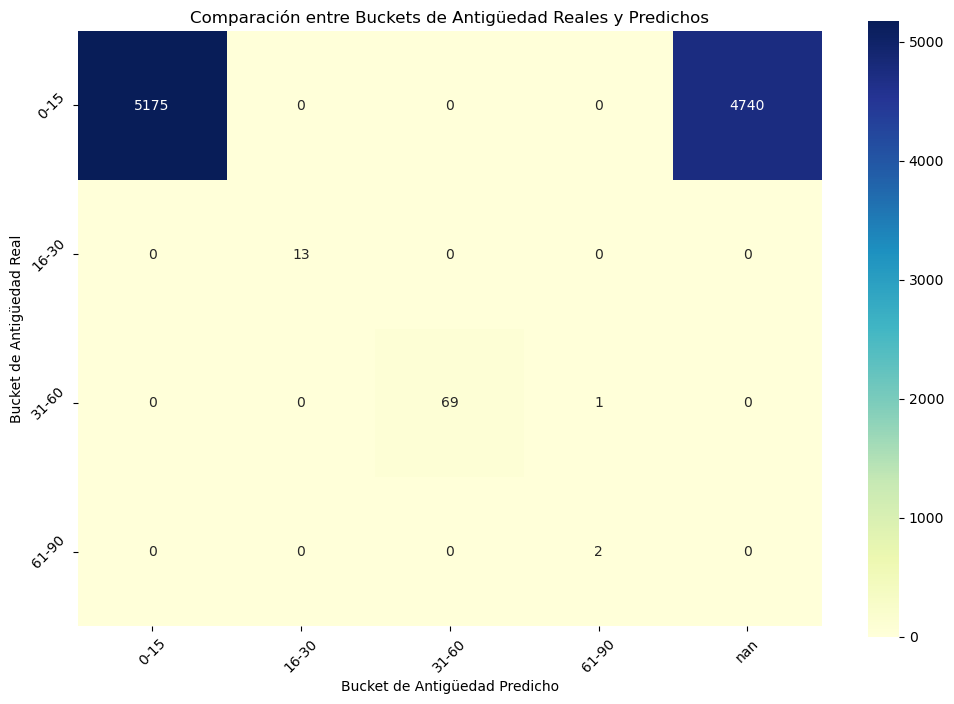

In [186]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Asegúrate de que 'due_in_date' y 'clear_date' estén en formato datetime
Final['due_in_date'] = pd.to_datetime(Final['due_in_date'])
Final['clear_date'] = pd.to_datetime(Final['clear_date'])

# Calcular la diferencia en días entre la fecha de vencimiento y la fecha de pago
Final['days_diff'] = (Final['clear_date'] - Final['due_in_date']).dt.days

# Función para mapear la diferencia en días a buckets de antigüedad
def map_to_aging_bucket(days_diff):
    if pd.isna(days_diff):
        return 'Desconocido'
    elif days_diff <= 15:
        return '0-15'
    elif days_diff <= 30:
        return '16-30'
    elif days_diff <= 60:
        return '31-60'
    elif days_diff <= 90:
        return '61-90'
    else:
        return '91+'

# Aplicar la función para crear la columna de buckets de antigüedad real
Final['real_aging_bucket'] = Final['days_diff'].apply(map_to_aging_bucket)

# Convertir 'Aging Bucket' a tipo de datos string para evitar problemas con categorías
Final['Aging Bucket'] = Final['Aging Bucket'].astype(str)

# Verificar si 'Desconocido' está en las categorías existentes y agregarlo si es necesario
if 'Desconocido' not in Final['Aging Bucket'].unique():
    Final['Aging Bucket'] = Final['Aging Bucket'].astype('category')
    Final['Aging Bucket'] = Final['Aging Bucket'].cat.add_categories('Desconocido')

# Limpiar y verificar la columna 'Aging Bucket'
Final['Aging Bucket'] = Final['Aging Bucket'].fillna('Desconocido')

# Crear una tabla de contingencia
contingency_table = pd.crosstab(Final['real_aging_bucket'], Final['Aging Bucket'])

# Crear el gráfico de calor
plt.figure(figsize=(12, 8))
sns.heatmap(contingency_table, annot=True, fmt='d', cmap='YlGnBu', cbar=True, square=True)
plt.xlabel('Bucket de Antigüedad Predicho')
plt.ylabel('Bucket de Antigüedad Real')
plt.title('Comparación entre Buckets de Antigüedad Reales y Predichos')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()


In [187]:
import pandas as pd

def generate_comparison_report(df):
    # Crear una tabla de contingencia
    contingency_table = pd.crosstab(df['real_aging_bucket'], df['Aging Bucket'])
    
    # Calcular el número total de observaciones
    total_observations = df.shape[0]
    
    # Calcular el número total de coincidencias exactas
    exact_matches = sum(contingency_table.values.diagonal())
    
    # Calcular el porcentaje de coincidencias exactas
    exact_match_percentage = (exact_matches / total_observations) * 100
    
    # Calcular el número total de discrepancias
    total_discrepancies = total_observations - exact_matches
    
    # Crear un resumen de la tabla de contingencia
    summary = []
    summary.append(f"Total de observaciones: {total_observations}")
    summary.append(f"Coincidencias exactas: {exact_matches}")
    summary.append(f"Porcentaje de coincidencias exactas: {exact_match_percentage:.2f}%")
    summary.append(f"Total de discrepancias: {total_discrepancies}")
    
    summary.append("\nTabla de contingencia:")
    summary.append(contingency_table.to_string())
    
    return "\n".join(summary)

# Usar la función para generar el reporte
report = generate_comparison_report(Final)

# Guardar el reporte en un archivo de texto
with open('comparacion_buckets.txt', 'w') as file:
    file.write(report)

print(report)


Total de observaciones: 10000
Coincidencias exactas: 5259
Porcentaje de coincidencias exactas: 52.59%
Total de discrepancias: 4741

Tabla de contingencia:
Aging Bucket       0-15  16-30  31-60  61-90   nan
real_aging_bucket                                 
0-15               5175      0      0      0  4740
16-30                 0     13      0      0     0
31-60                 0      0     69      1     0
61-90                 0      0      0      2     0


In [188]:
import pandas as pd

# Filtrar las observaciones con el bucket predicho como 'Desconocido'
unknown_predicted = Final[Final['Aging Bucket'] == 'Desconocido']

# Calcular si las observaciones están vencidas
# Una observación está vencida si 'clear_date' es anterior a 'due_in_date'
unknown_predicted['is_overdue'] = unknown_predicted['clear_date'] > unknown_predicted['due_in_date']

# Contar el número de observaciones vencidas y no vencidas
overdue_count = unknown_predicted['is_overdue'].sum()
not_overdue_count = (~unknown_predicted['is_overdue']).sum()

# Imprimir los resultados
print(f"Total de observaciones con bucket predicho como 'Desconocido': {unknown_predicted.shape[0]}")
print(f"Total de observaciones vencidas: {overdue_count}")
print(f"Total de observaciones no vencidas: {not_overdue_count}")


Total de observaciones con bucket predicho como 'Desconocido': 0
Total de observaciones vencidas: 0
Total de observaciones no vencidas: 0


In [189]:
# Revisar los valores únicos en la columna 'Aging Bucket'
print("Valores únicos en 'Aging Bucket':", Final['Aging Bucket'].unique())


Valores únicos en 'Aging Bucket': ['0-15', 'nan', '31-60', '16-30', '61-90']
Categories (6, object): ['0-15', '16-30', '31-60', '61-90', 'nan', 'Desconocido']


In [194]:
Final

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,due_in_date,baseline_create_date,cust_payment_terms,converted_usd,Aging Bucket,days_diff,real_aging_bucket,is_overdue
0,CA02,0140105686,SYSC llc,2020-04-13,2020.0,2.960623e+09,2020-03-30,2020-04-10,2020-03-31,CA10,2309.79,0-15,3,0-15,False
1,U001,0200744019,TARG us,2020-04-05,2020.0,1.930659e+09,2020-03-19,2020-04-03,2020-03-19,NAA8,11173.02,0-15,2,0-15,False
2,U001,0200418007,AM,2020-03-23,2020.0,1.930611e+09,2020-03-11,2020-03-26,2020-03-11,NAA8,3525.59,No Vencido,-3,No Vencido,True
3,U001,0200739534,OK systems,2020-05-01,2020.0,1.930788e+09,2020-04-15,2020-04-30,2020-04-15,NAA8,121105.65,0-15,1,0-15,False
4,U001,0200353024,DECA corporation,2020-04-21,2020.0,1.930817e+09,2020-04-23,2020-04-26,2020-04-16,NAM2,3726.06,No Vencido,-5,No Vencido,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,U001,0200769623,WAL-MAR in,2020-03-22,2020.0,1.930625e+09,2020-03-10,2020-03-25,2020-03-10,NAH4,13114.99,No Vencido,-3,No Vencido,True
9996,U001,0200769623,WAL-MAR corporation,2020-05-15,2020.0,1.930851e+09,2020-05-03,2020-05-18,2020-05-03,NAH4,8899.71,No Vencido,-3,No Vencido,True
9997,U001,0200148860,DOLLA co,2020-03-18,2020.0,1.930638e+09,2020-03-11,2020-03-26,2020-03-11,NAA8,4967.06,No Vencido,-8,No Vencido,True
9998,U001,0200900909,SYSCO co,2020-04-09,2020.0,1.930702e+09,2020-03-25,2020-04-09,2020-03-25,NAA8,1998.64,0-15,0,No Vencido,True
